In [1]:
from __future__ import annotations

In [2]:
from IPython.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [3]:
import os
import datetime
import numpy as np
import sklearn.metrics
import tensorflow as tf
import sklearn.datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Input, Conv2D, MaxPooling2D,Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
sns.set_style('dark')
sns.set(rc={'figure.figsize': (10, 10), 'axes.grid': False})

2024-10-12 09:44:43.125794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 09:44:43.147437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 09:44:43.153190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 09:44:43.182657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 09:44:44.670791: W tensorflow/compiler/tf2

In [4]:
rng = np.random.default_rng()

In [5]:
def plot_grid(X, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    imgs = X[rng.choice(np.arange(X.shape[0]), size=ax.shape)].reshape(*ax.shape, 28, 28)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [6]:
def plot_grid_and_label(X, y, model, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True, flatten_image=True, label_description=None):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    idx = rng.choice(np.arange(X.shape[0]), size=ax.shape)
    imgs, labels = X[idx], y[idx]
    inputs = imgs.reshape(-1, *imgs.shape[2:])
    
    if flatten_image:
        inputs = inputs.reshape(nrows * ncols, -1)

    map_label = (lambda x: x) if label_description is None else (lambda x: label_description[x])
        
    preds = np.argmax(tf.nn.softmax(model.predict(inputs)), axis=-1).reshape(nrows, ncols)

    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            ax[i, j].set_title(f'label: {map_label(labels[i, j])}, prediction: {map_label(preds[i, j])}')
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [7]:
X, y = sklearn.datasets.fetch_openml('Kuzushiji-49', version=1, return_X_y=True, as_frame=False, parser='auto')
y = np.array(list(map(int, y)))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [30]:
# Работа с дисбалансом классов

ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()
adasyn = ADASYN()

disbalance_fn = smote
X_train, y_train = disbalance_fn.fit_resample(X_train, y_train)

In [9]:
label_description = [
     'A',   'I',   'U',  'E',  'O',
    'KA',  'KI',  'KU', 'KE', 'KO',
    'SA', 'SHI',  'SU', 'SE', 'SO',
    'TA', 'CHI', 'TSU', 'TE', 'TO',
    'NA',  'NI',  'NU', 'NE', 'NO',
    'HA',  'HI',  'FU', 'HE', 'HO',
    'MA',  'MI',  'MU', 'ME', 'MO',
    'YA',         'YU',       'YO',
    'RA',  'RI',  'RU', 'RE', 'RO',
    'WA',  'II',        'EE', 'WO',
     'N',  'IT'
]

In [10]:
class_count = len(label_description)

In [11]:
counts = { j: np.sum(y_train == i) for i, j in enumerate(label_description) }

In [12]:
counts # what to do with imbalanced classes?

{'A': 5214,
 'I': 5277,
 'U': 5208,
 'E': 684,
 'O': 5235,
 'KA': 5268,
 'KI': 5240,
 'KU': 5213,
 'KE': 4136,
 'KO': 5271,
 'SA': 5211,
 'SHI': 5221,
 'SU': 5248,
 'SE': 3700,
 'SO': 3367,
 'TA': 5245,
 'CHI': 2216,
 'TSU': 5273,
 'TE': 5233,
 'TO': 5255,
 'NA': 5275,
 'NI': 5177,
 'NU': 1822,
 'NE': 2206,
 'NO': 5228,
 'HA': 5260,
 'HI': 4421,
 'FU': 5251,
 'HE': 5273,
 'HO': 1725,
 'MA': 5250,
 'MI': 2641,
 'MU': 1485,
 'ME': 2952,
 'MO': 5251,
 'YA': 5318,
 'YU': 1358,
 'YO': 5261,
 'RA': 5294,
 'RI': 5241,
 'RU': 5315,
 'RE': 5270,
 'RO': 1844,
 'WA': 2068,
 'II': 368,
 'EE': 345,
 'WO': 5224,
 'N': 5272,
 'IT': 3074}

In [14]:
sorted_count = sorted(counts.items(), key=lambda item: item[1])

In [15]:
sorted_count

[('A', 348),
 ('I', 348),
 ('U', 348),
 ('E', 348),
 ('O', 348),
 ('KA', 348),
 ('KI', 348),
 ('KU', 348),
 ('KE', 348),
 ('KO', 348),
 ('SA', 348),
 ('SHI', 348),
 ('SU', 348),
 ('SE', 348),
 ('SO', 348),
 ('TA', 348),
 ('CHI', 348),
 ('TSU', 348),
 ('TE', 348),
 ('TO', 348),
 ('NA', 348),
 ('NI', 348),
 ('NU', 348),
 ('NE', 348),
 ('NO', 348),
 ('HA', 348),
 ('HI', 348),
 ('FU', 348),
 ('HE', 348),
 ('HO', 348),
 ('MA', 348),
 ('MI', 348),
 ('MU', 348),
 ('ME', 348),
 ('MO', 348),
 ('YA', 348),
 ('YU', 348),
 ('YO', 348),
 ('RA', 348),
 ('RI', 348),
 ('RU', 348),
 ('RE', 348),
 ('RO', 348),
 ('WA', 348),
 ('II', 348),
 ('EE', 348),
 ('WO', 348),
 ('N', 348),
 ('IT', 348)]

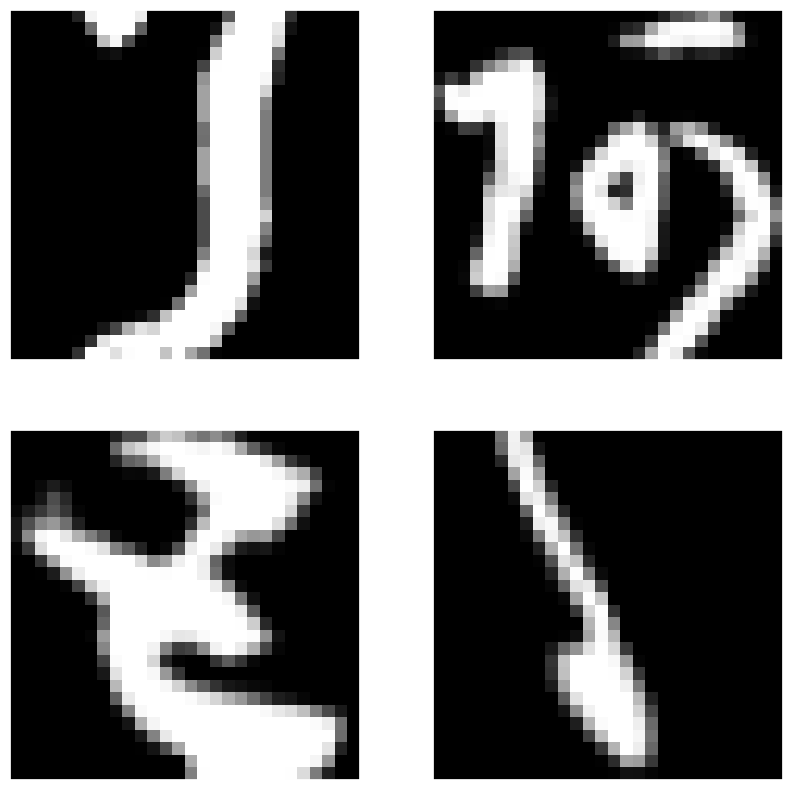

In [16]:
plot_grid(X_train)

## Flattened images
Use Dense layers

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [18]:
y_train_cat = to_categorical(y_train, class_count)
y_val_cat = to_categorical(y_val, class_count)
y_test_cat = to_categorical(y_test, class_count)

In [34]:
model = None

In [15]:
# create model, this model should accept a flattened image

model = Sequential()
model.add(Input((784,)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(Dense(196))
model.add(Activation('relu'))
model.add(Dropout(0.01))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.01))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.01))
model.add(Dense(class_count))
model.add(Activation('softmax'))

I0000 00:00:1728687715.515482   12861 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728687715.538776   12861 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728687715.538844   12861 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728687715.540567   12861 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728687715.540633   12861 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 196)            │       100,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        25,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 49)             │         3,185 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 49)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,728,501 (6.59 MB)

 Trainable params: 1,728,501 (6.59 MB)

 Non-trainable params: 0 (0.00 B)

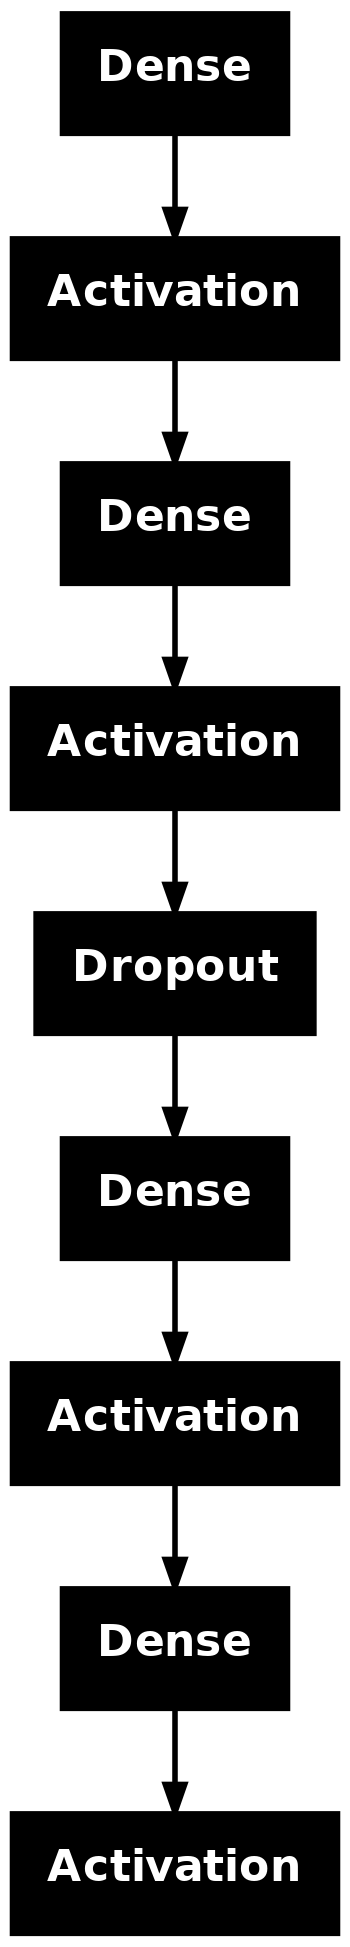

In [21]:
plot_model(model)

In [14]:
logdir = ''.join(['logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S.keras')])

In [15]:
logdir

'/logs/kuzushiji-49/20241009-001104.keras'

In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(logdir, save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [17]:
#  Определяем параметры обучения
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

In [18]:
np.random.seed(1337)

batch_size = 128
nr_iterations = 10

net_res = model.fit(
    X_train,
    y_train_cat,
    batch_size = batch_size,
    epochs = nr_iterations,
    verbose = 1,
    validation_data = (X_val, y_val_cat),
)

2024-10-12 09:02:01.308694: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 955777536 exceeds 10% of free system memory.
2024-10-12 09:02:06.198147: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 955777536 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1728687728.713672   13098 service.cc:146] XLA service 0x7f165c001ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728687728.716728   13098 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GT 1030, Compute Capability 6.1
2024-10-12 09:02:08.898296: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-12 09:02:09.469031: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   6/1191 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.0115 - loss: 29.6234 

I0000 00:00:1728687735.966635   13098 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1191/1191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2982 - loss: 3.4462

2024-10-12 09:02:35.820025: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 318592512 exceeds 10% of free system memory.
2024-10-12 09:02:36.015806: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 318592512 exceeds 10% of free system memory.


1191/1191 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.2983 - loss: 3.4451 - val_accuracy: 0.7569 - val_loss: 0.9582
Epoch 2/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7289 - loss: 1.0526 - val_accuracy: 0.8213 - val_loss: 0.7076
Epoch 3/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7919 - loss: 0.8045 - val_accuracy: 0.8437 - val_loss: 0.6174
Epoch 4/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8222 - loss: 0.6907 - val_accuracy: 0.8610 - val_loss: 0.5575
Epoch 5/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8410 - loss: 0.6224 - val_accuracy: 0.8688 - val_loss: 0.5283
Epoch 6/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8560 - loss: 0.5606 - val_accuracy: 0.8796 - val_loss: 0.4923
Epoch 7/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8683 - loss: 0.5240 - val_accuracy: 0.8872 - val_loss: 0.4828
Epoch 8/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8779 - loss: 0.48

In [19]:
model.save('kuzushiji_49_flat.keras')

In [20]:
model_loaded = load_model('kuzushiji_49_flat.keras')

In [23]:
images = X_test.reshape(-1, 28, 28, 1) # normalize if needed

In [24]:
images.shape

(67728, 28, 28, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
ARG max: [[10 19]
 [40  2]]


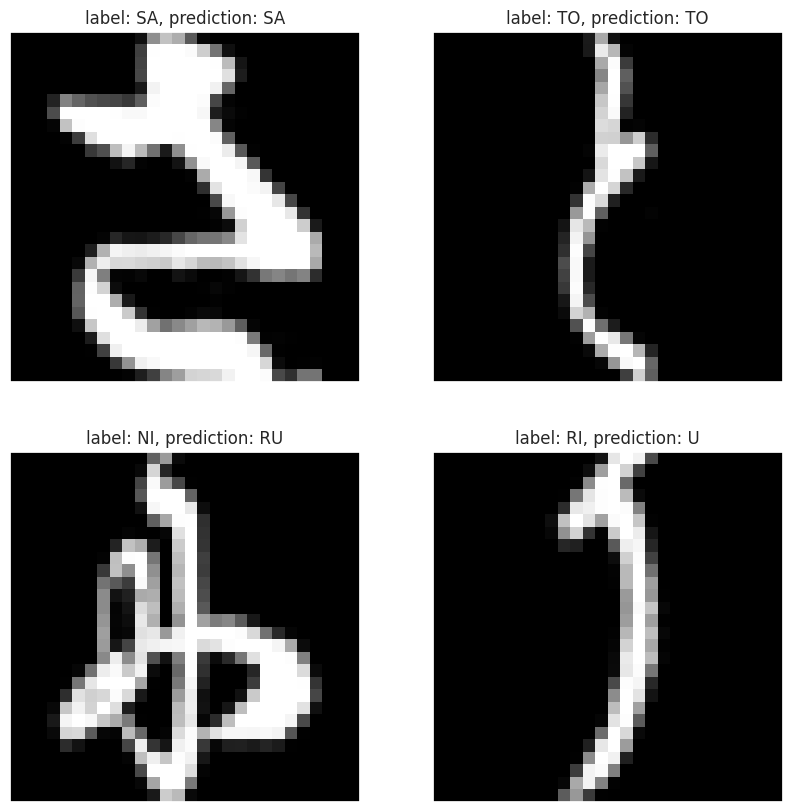

In [26]:
plot_grid_and_label(images, y_test, model, label_description=label_description)

In [21]:
y_pred = model_loaded.predict(X_test)

2024-10-12 09:05:00.995855: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 424790016 exceeds 10% of free system memory.


2117/2117 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [22]:
y_pred_val = np.array([np.argmax(item) for item in y_pred])

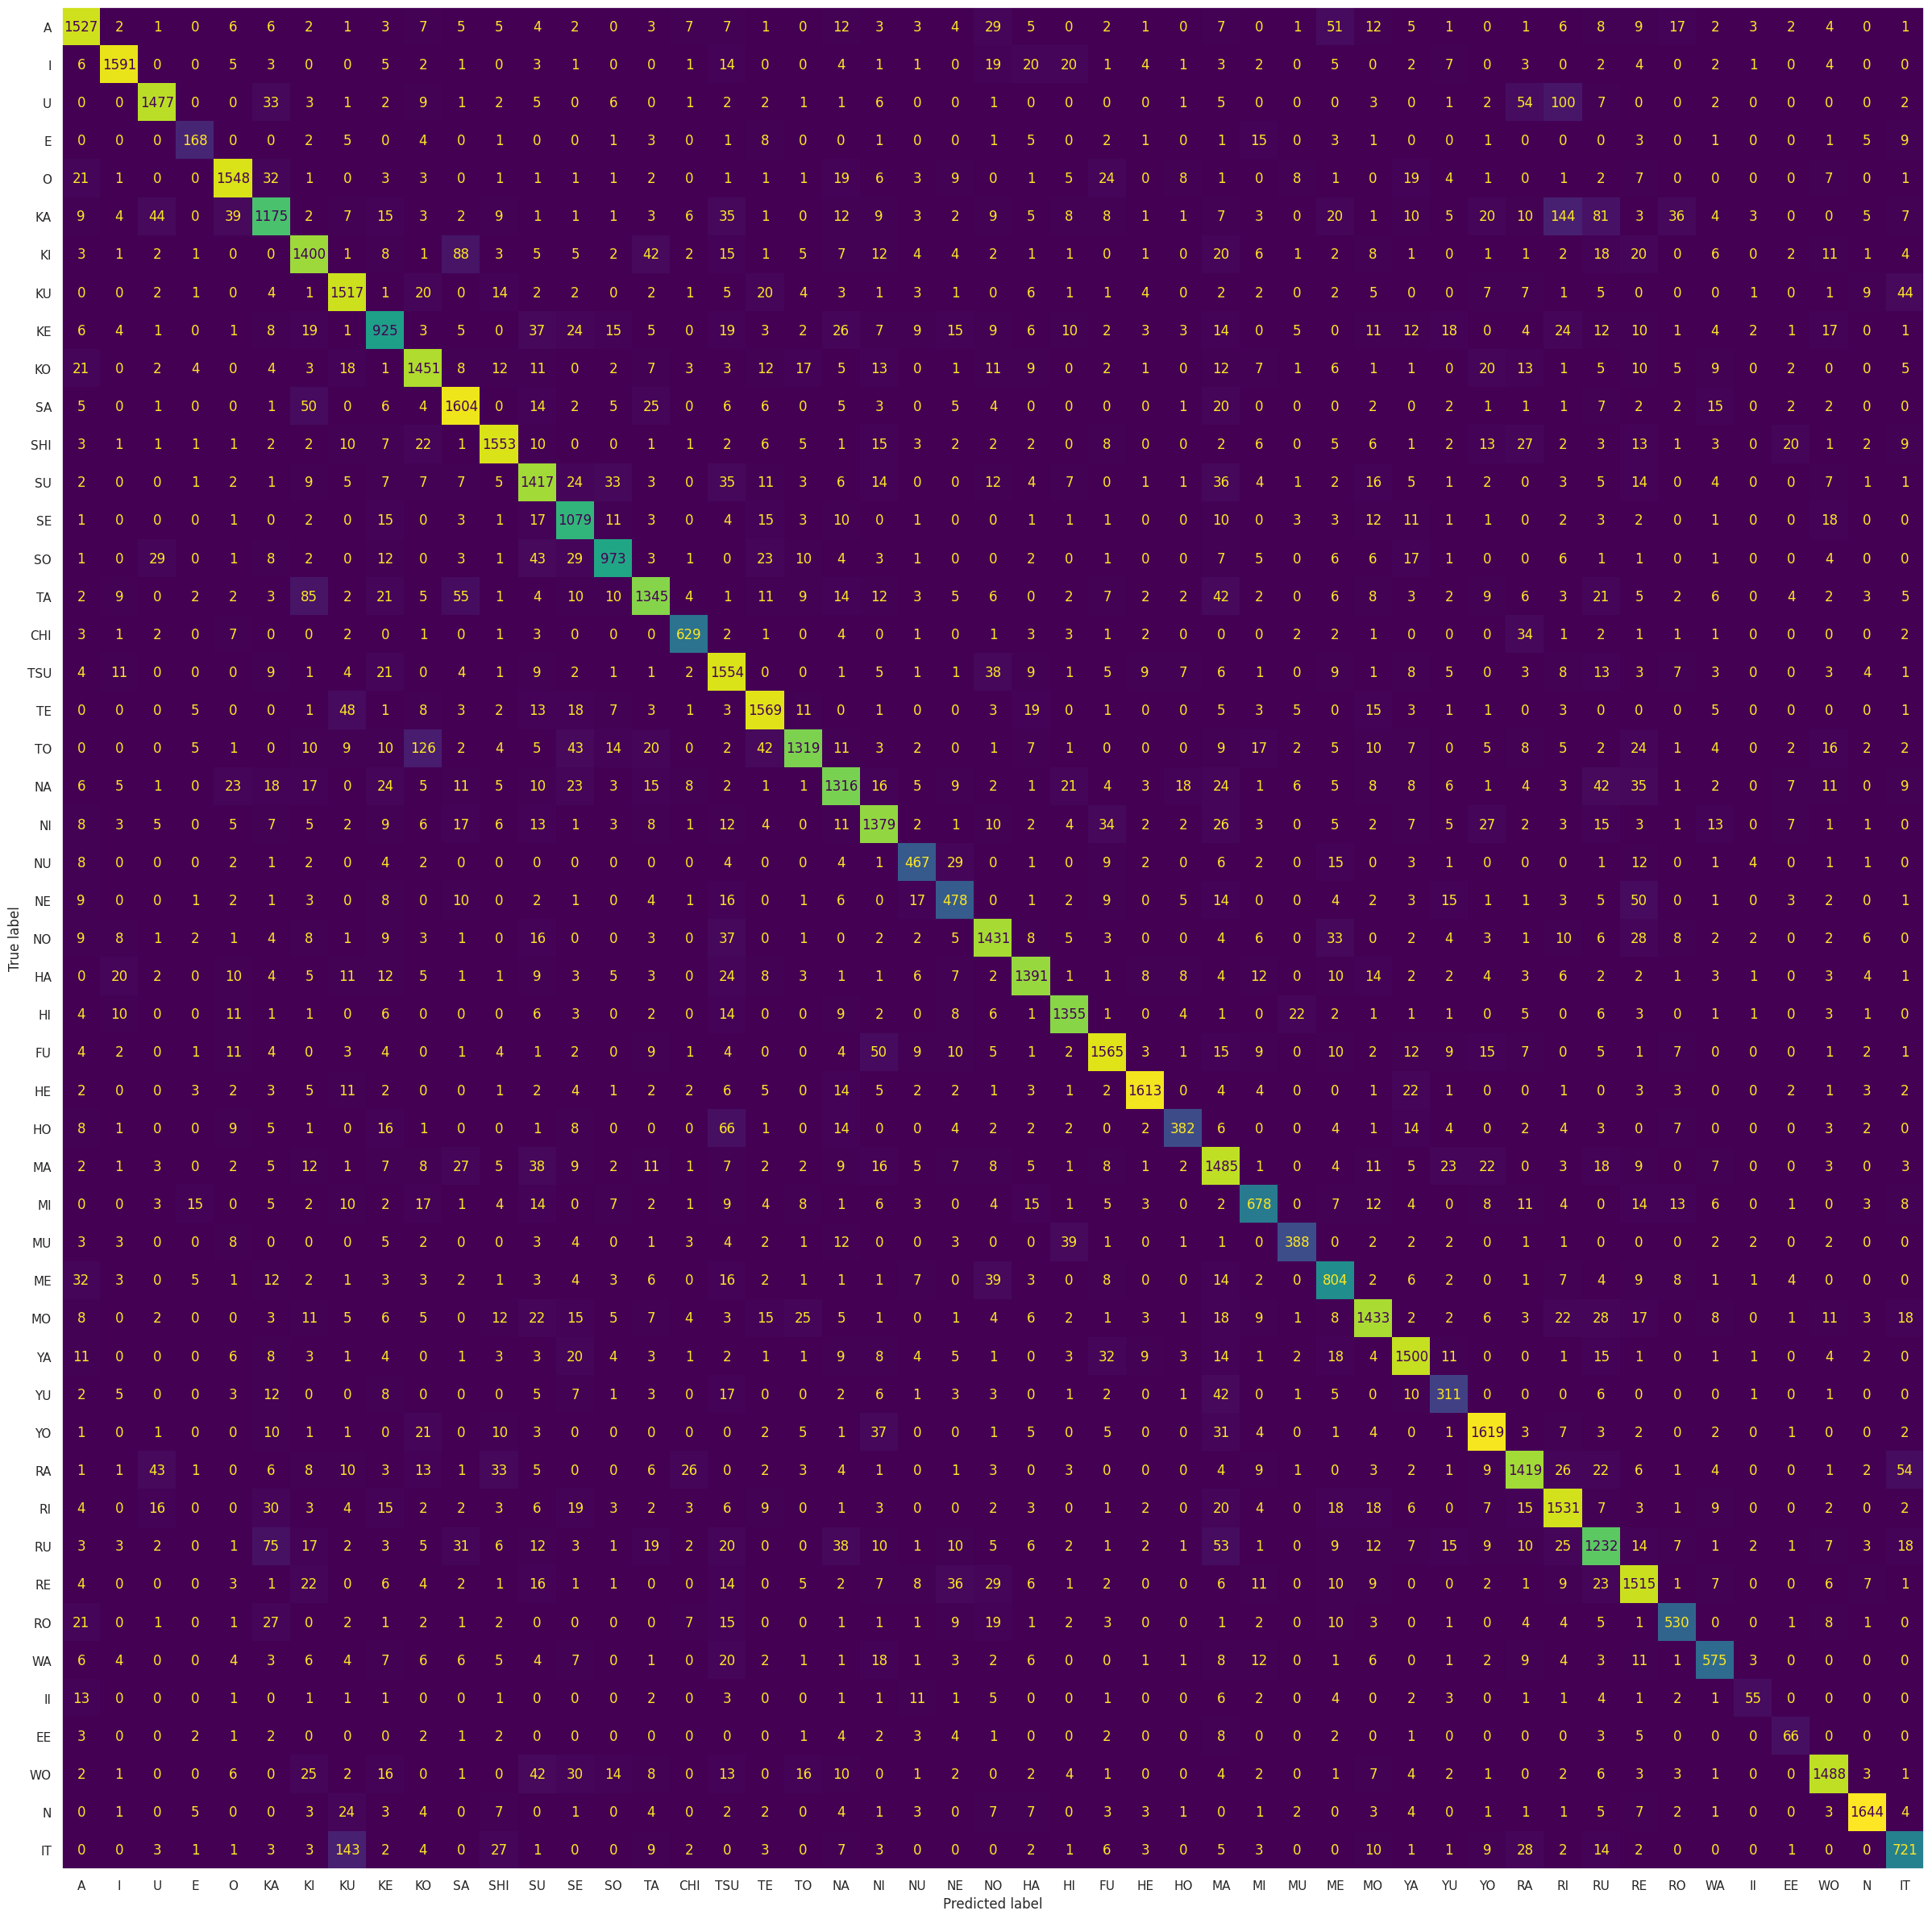

In [23]:
_, ax = plt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [23]:
accuracy = y_test == y_pred_val
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

0.8805546380389999

## Actual images
Use Conv2D layers with Dense layer on top

In [19]:
np.random.seed(42)

In [20]:
batch_size = 128
epochs = 6

# input image dimensions
img_rows, img_cols = 28, 28

In [21]:
X_train_img = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val_img = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_test_img = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [22]:
X_train_img = X_train_img.astype('float32')
X_val_img = X_val_img.astype('float32')
X_test_img = X_test_img.astype('float32')
X_train_img /= 255
X_test_img /= 255
X_val_img /= 255

print('{} train samples, {} test samples'.format(len(X_train), len(X_val)))

152388 train samples, 50796 test samples


In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1728690402.105693   24904 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728690402.154957   24904 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728690402.155020   24904 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728690402.156601   24904 cuda_exec

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 49)             │         6,321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,204,913 (4.60 MB)

 Trainable params: 1,204,913 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

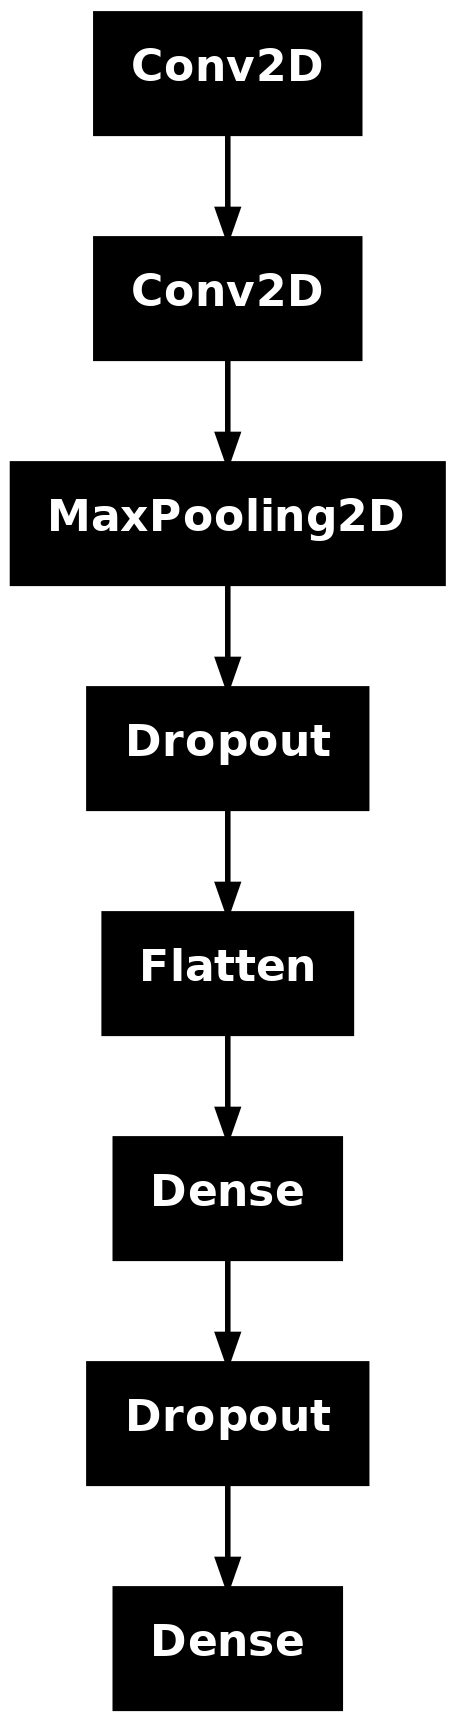

In [19]:
tf.keras.utils.plot_model(model)

In [25]:
model.fit(X_train_img, y_train_cat,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_img, y_val_cat))

2024-10-12 09:47:22.634477: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 477888768 exceeds 10% of free system memory.
2024-10-12 09:47:24.861827: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 477888768 exceeds 10% of free system memory.


Epoch 1/6


I0000 00:00:1728690446.343584   25594 service.cc:146] XLA service 0x7f175400a470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728690446.344275   25594 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GT 1030, Compute Capability 6.1
2024-10-12 09:47:26.440065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-12 09:47:26.769834: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   2/1191 ━━━━━━━━━━━━━━━━━━━━ 1:10 59ms/step - accuracy: 0.0215 - loss: 3.8843 

2024-10-12 09:47:32.800910: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1728690452.812984   25594 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1191/1191 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5698 - loss: 1.6776

2024-10-12 09:48:28.021569: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads

2024-10-12 09:48:28.279503: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 159296256 exceeds 10% of free system memory.
2024-10-12 09:48:28.382338: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 159296256 exceeds 10% of free system memory.


1191/1191 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - accuracy: 0.5700 - loss: 1.6772 - val_accuracy: 0.8864 - val_loss: 0.4240
Epoch 2/6
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.8163 - loss: 0.6694 - val_accuracy: 0.9167 - val_loss: 0.3144
Epoch 3/6
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.8543 - loss: 0.5161 - val_accuracy: 0.9283 - val_loss: 0.2689
Epoch 4/6
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.8720 - loss: 0.4502 - val_accuracy: 0.9342 - val_loss: 0.2431
Epoch 5/6
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.8875 - loss: 0.3913 - val_accuracy: 0.9404 - val_loss: 0.2211
Epoch 6/6
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.8986 - loss: 0.3531 - val_accuracy: 0.9430 - val_loss: 0.2115


In [27]:
model.save('kuzushiji_49_conv.keras')

In [28]:
loaded_conv = load_model('kuzushiji_49_conv.keras')

In [ ]:
logdir = os.path.join('logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(logdir, save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [ ]:
# compile the model, make sure to add accuracy metric

In [ ]:
# train the model, make sure to use callbacks and validation dataset

In [44]:
images = X_test.reshape(-1, 28, 28, 1) # normalize if needed

In [45]:
plot_grid_and_label(images, y_test, model, label_description=label_description, flatten_image=False)

NameError: name 'plot_grid_and_label' is not defined

In [30]:
y_pred = loaded_conv.predict(X_test_img)
y_pred_val = np.array([np.argmax(item) for item in y_pred])

2024-10-12 09:55:32.028999: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 212395008 exceeds 10% of free system memory.


2117/2117 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


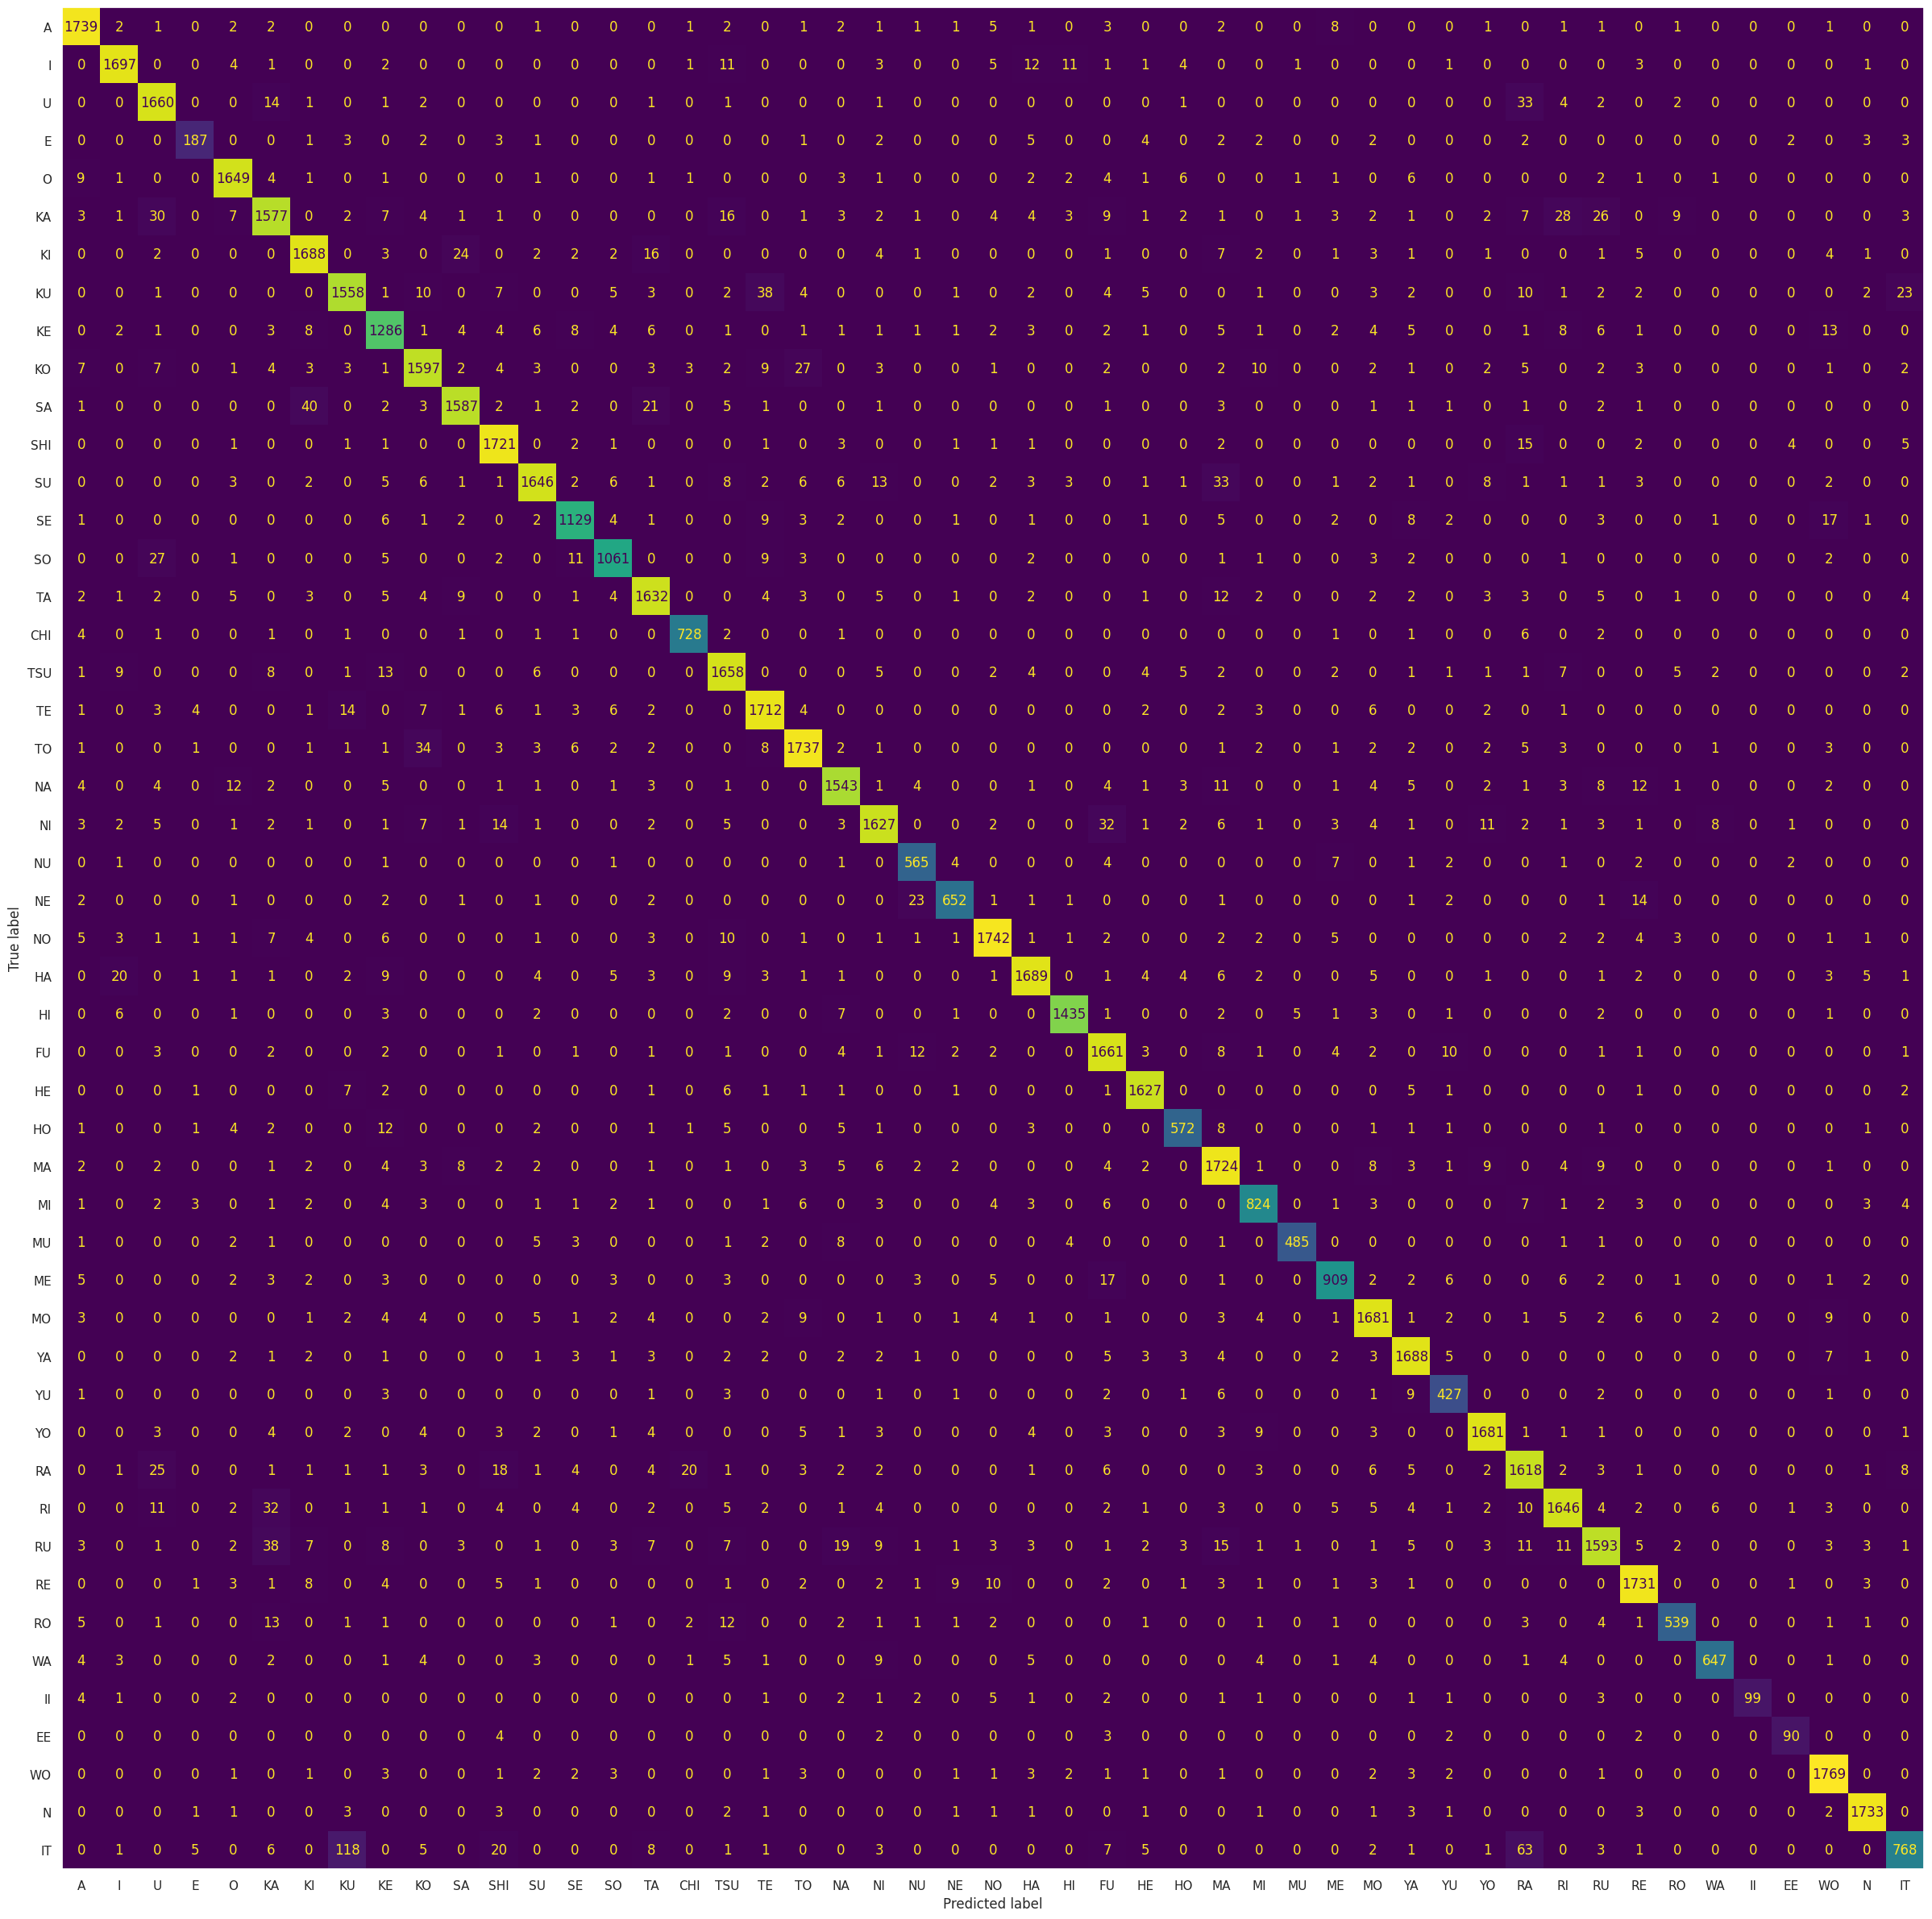

In [47]:
_, ax = plt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [31]:
accuracy = y_test == y_pred_val
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

0.9343150420884457